In [1]:
!git clone https://github.com/facebookresearch/detectron2.git

Cloning into 'detectron2'...
Updating files:  76% (629/827)
Updating files:  77% (637/827)
Updating files:  78% (646/827)
Updating files:  79% (654/827)
Updating files:  80% (662/827)
Updating files:  81% (670/827)
Updating files:  82% (679/827)
Updating files:  83% (687/827)
Updating files:  84% (695/827)
Updating files:  85% (703/827)
Updating files:  86% (712/827)
Updating files:  87% (720/827)
Updating files:  88% (728/827)
Updating files:  89% (737/827)
Updating files:  90% (745/827)
Updating files:  91% (753/827)
Updating files:  92% (761/827)
Updating files:  93% (770/827)
Updating files:  94% (778/827)
Updating files:  95% (786/827)
Updating files:  96% (794/827)
Updating files:  97% (803/827)
Updating files:  98% (811/827)
Updating files:  99% (819/827)
Updating files: 100% (827/827)
Updating files: 100% (827/827), done.


In [2]:
%cd detectron2
!pip install -U .

c:\Project\SkincareApp\skincareApp\machine_learning\detectron2


C:\Users\Folka\AppData\Roaming\Python\Python312\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


Processing c:\project\skincareapp\skincareapp\machine_learning\detectron2
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  ERROR: Error [WinError 225] Operation did not complete successfully because the file contains a virus or potentially unwanted software while executing command python setup.py egg_info
ERROR: Could not install packages due to an OSError: [WinError 225] Operation did not complete successfully because the file contains a virus or potentially unwanted software



In [3]:
import os
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# Import some common libraries
import numpy as np
import cv2
import random
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

# Import custom functions
from detectron2.data.datasets import register_coco_instances
import wandb

In [4]:
# Register your dataset
register_coco_instances("my_dataset_train", {}, "/kaggle/input/skindatamaskrcnn/custom_data/train/annotations.json", "/kaggle/input/skindatamaskrcnn/custom_data/train/images")
register_coco_instances("my_dataset_val", {}, "/kaggle/input/skindatamaskrcnn/custom_data/val/annotations.json", "/kaggle/input/skindatamaskrcnn/custom_data/val/images")

In [5]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_key = user_secrets.get_secret("wandb_api")

In [6]:
!wandb login $wandb_key

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [7]:
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

# Wandb 
wandb.login
wandb.init(project="hkskin", entity="raghvender")

# Configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 4

# # Let training initialize from model zoo
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
# cfg.SOLVER.IMS_PER_BATCH = 2
# cfg.SOLVER.BASE_LR = 0.0025
# cfg.SOLVER.MAX_ITER = 10000  # Adjust according to your dataset size
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(["acne", "darkcircles", "openpores", "finelines", "wrinkle", "pigmentation"])  # number of classes

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 1e-4 # 0.0025  
dataset_dicts = DatasetCatalog.get("my_dataset_train")
n_images = len(dataset_dicts)
cfg.SOLVER.MAX_ITER = (n_images // cfg.SOLVER.IMS_PER_BATCH) * 50 # (5000 // 2) * 50
# cfg.SOLVER.MAX_ITER = (5000 // 2) * 20  # Example for ~20 epochs, adjust as necessary
cfg.SOLVER.STEP = [int((n_images / cfg.SOLVER.IMS_PER_BATCH) * 10), int((n_images / cfg.SOLVER.IMS_PER_BATCH) * 15)]  # Example steps for LR decay
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6  # Number of classes

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

# Evaluation
# Evaluation on Validation Dataset
val_evaluator = COCOEvaluator("my_dataset_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
eval_metrics = inference_on_dataset(trainer.model, val_loader, val_evaluator)
wandb.log(eval_metrics)
# print(inference_on_dataset(trainer.model, val_loader, val_evaluator))

# Evaluation on Training Dataset
train_evaluator = COCOEvaluator("my_dataset_train", cfg, False, output_dir="./output/")
train_loader = build_detection_test_loader(cfg, "my_dataset_train")
train_eval_metrics = inference_on_dataset(trainer.model, train_loader, train_evaluator)
wandb.log(train_eval_metrics)
# print(inference_on_dataset(trainer.model, train_loader, train_evaluator))

wandb: Currently logged in as: raghvender. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.16.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.16.2
wandb: Run data is saved locally in /kaggle/working/detectron2/wandb/run-20240425_060048-kb27sp6l
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run stilted-violet-1
wandb: ⭐️ View project at https://wandb.ai/raghvender/hkskin
wandb: 🚀 View run at https://wandb.ai/raghvender/hkskin/runs/kb27sp6l


[04/25 06:01:20 d2.data.datasets.coco]: Loaded 4009 images in COCO format from /kaggle/input/skindatamaskrcnn/custom_data/train/annotations.json
[04/25 06:01:22 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_si

model_final_f10217.pkl: 178MB [00:00, 225MB/s]                           


[04/25 06:01:24 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[04/25 06:01:35 d2.utils.events]:  eta: 5:25:10  iter: 19  total_loss: 5.517  loss_cls: 1.817  loss_box_reg: 0.005384  loss_mask: 0.6907  loss_rpn_cls: 2.862  loss_rpn_loc: 0.1434    time: 0.3840  last_time: 0.3904  data_time: 0.0245  last_data_time: 0.0103   lr: 1.9981e-06  max_mem: 3095M


2024-04-25 06:01:38.082858: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 06:01:38.082982: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 06:01:38.235732: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[04/25 06:01:56 d2.utils.events]:  eta: 5:24:27  iter: 39  total_loss: 5.52  loss_cls: 1.737  loss_box_reg: 0.006748  loss_mask: 0.6904  loss_rpn_cls: 2.907  loss_rpn_loc: 0.1281    time: 0.3841  last_time: 0.3582  data_time: 0.0108  last_data_time: 0.0114   lr: 3.9961e-06  max_mem: 3095M
[04/25 06:02:03 d2.utils.events]:  eta: 5:22:40  iter: 59  total_loss: 4.737  loss_cls: 1.594  loss_box_reg: 0.00854  loss_mask: 0.6901  loss_rpn_cls: 2.334  loss_rpn_loc: 0.1376    time: 0.3790  last_time: 0.3464  data_time: 0.0108  last_data_time: 0.0106   lr: 5.9941e-06  max_mem: 3096M
[04/25 06:02:11 d2.utils.events]:  eta: 5:20:12  iter: 79  total_loss: 3.623  loss_cls: 1.392  loss_box_reg: 0.02056  loss_mask: 0.6898  loss_rpn_cls: 1.385  loss_rpn_loc: 0.1128    time: 0.3777  last_time: 0.4031  data_time: 0.0103  last_data_time: 0.0103   lr: 7.9921e-06  max_mem: 3096M
[04/25 06:02:18 d2.utils.events]:  eta: 5:19:53  iter: 99  total_loss: 3.174  loss_cls: 1.178  loss_box_reg: 0.06739  loss_mask: 0

In [8]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer
import cv2
import matplotlib.pyplot as plt

def setup_cfg():
    cfg = get_cfg()
    # Load model config and pretrained model
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6  # Your number of classes here
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # Path to the model you've trained
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set a threshold for this model
    cfg.DATASETS.TEST = ("my_dataset_val", )
    return cfg

In [9]:
cfg = setup_cfg()
predictor = DefaultPredictor(cfg)

[04/25 11:47:08 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


In [10]:
def infer_and_visualize(image_path):
    im = cv2.imread(image_path)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get(cfg.DATASETS.TEST[0]),
                   scale=1.2,
                   instance_mode=ColorMode.IMAGE_BW  # Removes the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(14, 10))
    plt.imshow(cv2.cvtColor(v.get_image(), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

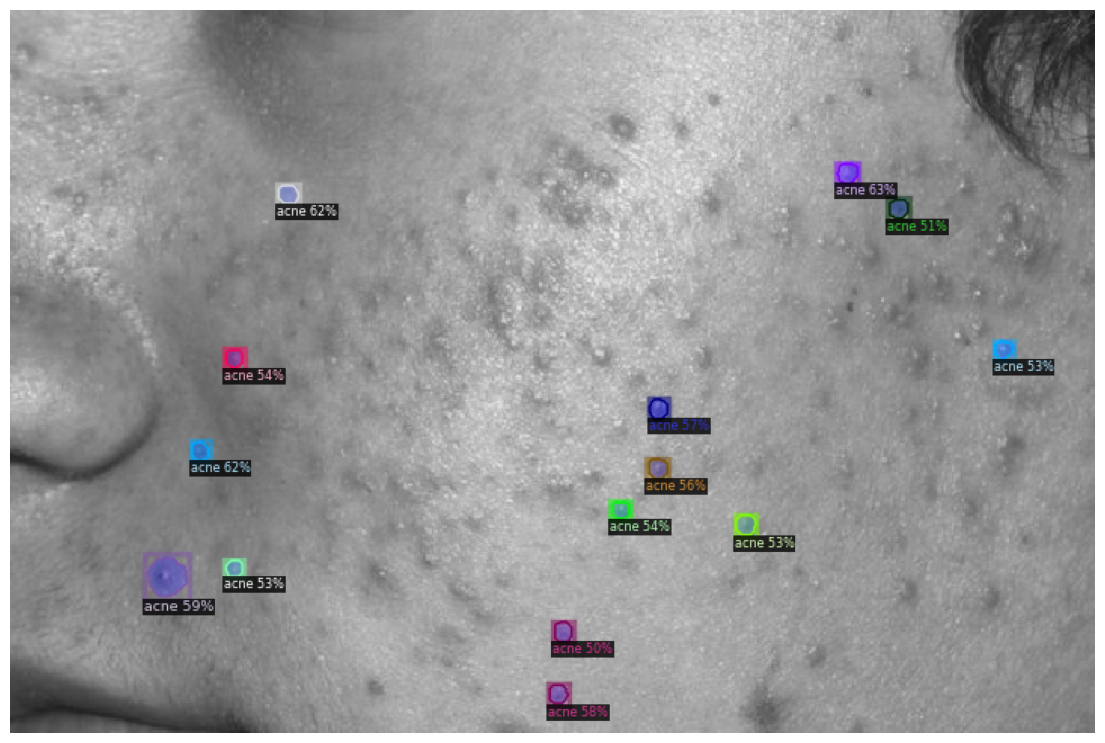

In [11]:
test_image_path = '/kaggle/input/test-skin-images/test.jpg'  # Update this to the path of your test image
infer_and_visualize(test_image_path)